In [ ]:
#

In [1]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports (matplotlib, matplotlib.finance)
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
#from matplotlib.finance import volume_overlay, volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance
import matplotlib.patheffects as PathEffects
    # [plt.text object].set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    # plt.text reference: https://matplotlib.org/api/text_api.html#matplotlib.text.Text

# API-specific imports (local install required; do NOT use default pip install)
import gdax
    # Python setup.py install with environment activated to install/use
    # Install locally with 'python setup.py install' & development branch of gdax-python checked out
    # Do not use default gdax pip install package - that version of the package is currently broken
        # Default pip install has broken mongo connection and websocket connection close() error

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.models import model_from_json
from keras import backend as K

# autoSR() function import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9284325510298947951
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9222031934
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17473169347682797882
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
firstUpdate_bids = False
firstUpdate_asks = False

# Value to track if feature_creation_inital() was run
    # Inital value = False
inital_feature_run = False

In [3]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [4]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        mongo_client['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)

# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format 
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    #save_csv()
    
    # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)

In [5]:
# Read in raw data from csv, 'raw_data' folder
    # 'raw_data' folder has 1hr of scraped data (snapshot + l2 response updates)
    # 'test_data' folder only has 10 minutes of scraped data 
def raw_csv_load():
    global request_log_df
    global snapshot_asks_df
    global snapshot_bids_df
    global l2update_df
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_4
  
    snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    request_log_df= pd.read_csv("raw_data/request_log.csv")
    
    #l2update_df (1 hour of data) split into 4 15-min dataframes/csvs
    l2update_15min_1 = pd.read_csv("raw_data/l2update_15min_1.csv",dtype ={'size':float})
    l2update_15min_2 = pd.read_csv("raw_data/l2update_15min_2.csv",dtype ={'size':float})
    l2update_15min_3 = pd.read_csv("raw_data/l2update_15min_3.csv",dtype ={'size':float})
    l2update_15min_4 = pd.read_csv("raw_data/l2update_15min_4.csv",dtype ={'size':float})


In [6]:
##### Request 15minute chart data #####

def chart_15m_request(request_log_df):
    
    global chart_15m_df
    request_start = request_log_df['iso'][1]
    request_end = request_log_df['iso'][0]

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')

In [7]:
# Auto support/resistance adapted into function 
    # Using estimate_bandwidth and meanshift() from sklearn.cluster library
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    
    global ml_results_modified
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
    
    # Convert ml_results into sorted int array
    ml_results_modified =np.asarray(ml_results)
    ml_results_modified =np.trunc(ml_results_modified).astype(int)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
    # Remove duplicates from int conversion
    ml_results_modified_set=set(ml_results_modified)
    ml_results_modified = list(ml_results_modified_set)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
    ml_results_modified
            
    return ml_results_modified

In [8]:
def generate_chart(dataframe):

    matplotlib.rcParams.update({'font.size': 14})
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 14))
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],\
                      chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30,ha="right")
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper label set at 20,18/20,14 chart size
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-10), max(chart_15m_df['high'])+10, 10))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.2', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    ml_results_modified = autoSR(chart_15m_df)
    
    # Add S/R labels to chart
        # count increment is used for staggering of labels in conjunction with modulus
        
    count = 1
    for k in ml_results_modified:
        
        #count = count+ 2.12
        ax.axhline(y=k)
       
        if count%3 == 0:
            plt.text(y=k,s=k,x=count-5,color='blue',rotation=45,size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 1:
            plt.text(y=k,s=k,x=count+5,color='blue',rotation=45,size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 2:
            plt.text(y=k,s=k,x=count+16,color='blue',rotation=45, size ='large').set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        
        
        count = count +1 
    #plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

In [9]:
# create and set inital/placeholder values for size_delta, position, and sr_prox_value/line input features 
    # run once upon new scrape only
def feature_creation_inital():
    global inital_feature_run
    
    if inital_feature_run == False:
           
        # Set inital size delta l2 snapshot - use decimal point to force as float
        snapshot_asks_df['size_delta'] = 0.0
        snapshot_bids_df['size_delta'] = 0.0

        # Set inital position for l2 snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index +1
        snapshot_bids_df['position'] = snapshot_bids_df.index +1

        # Reverse index for sell/asks
        # snapshot_asks_df =snapshot_asks_df[::-1]
        # Reverse inital position indicator for bids/buy side
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev

        # Set inital proximity value and inital value for nearest prox line
        snapshot_asks_df['sr_prox_value'] = 0
        snapshot_asks_df['sr_prox_line'] = 0
        snapshot_bids_df['sr_prox_value'] = 0
        snapshot_bids_df['sr_prox_line'] = 0
        
        # Create flag/boolean column for is_line feature - key prediction value for model
        snapshot_asks_df['is_line'] = 0
        snapshot_bids_df['is_line'] = 0
        
        # Set feature_creation_inital_run flag to True once run
        feature_creation_inital_run = True
        print("run")   
    elif inital_feature_run == True:
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        print("pass")
        pass

In [114]:
# Seperation of l2_updates into 4 15-min seperate l2 updates
     #l2update_df (1 hour of data) split into 4 15-min dataframes/csvs
# l2update_df.count()
def l2update_1hr_split(l2update_df):
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_3
    
    global l2update_time_df
    
    # 193848/4 = 48462
        # 48462
        # 96924
        # 145386
        # 193848
    l2update_15min_1=l2update_df[:48462]
    l2update_15min_2=l2update_df[48462:96924]
    l2update_15min_3=l2update_df[96924:145386]
    l2update_15min_4=l2update_df[145386:193848]
    l2update_15min_1.to_csv("raw_data/l2update_15min_1.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_2.to_csv("raw_data/l2update_15min_2.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_3.to_csv("raw_data/l2update_15min_3.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_4.to_csv("raw_data/l2update_15min_4.csv",header=True,encoding='utf-8',index =False)
    
    # Add l2update_15min segement iso times to dataframe
    # Predicted vs actual for each 15 min section of L2 update
    # Create dataframe with start time of every l2update segement
    time.sleep(0.5)
    l2update_15min_1.reset_index(inplace=True,drop = True)
    l2update_15min_2.reset_index(inplace=True,drop = True)
    l2update_15min_3.reset_index(inplace=True,drop = True)
    l2update_15min_4.reset_index(inplace=True,drop = True)
    time.sleep(0.5)
    l2update_time_df=pd.DataFrame.from_dict(data={"l2update_15min_1":l2update_15min_1['time'][0],
                                "l2update_15min_2":l2update_15min_2['time'][0],
                                "l2update_15min_3":l2update_15min_3['time'][0],
                                "l2update_15min_4":l2update_15min_4['time'][0]},orient='index')

    # Change time label to iso for chart generation function
    l2update_time_df.columns = ["iso"]


In [12]:
# L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
    # Applied to both snapshot_bids_df and snapshot_asks_df
    # Must be run before sr_update()
def l2_state_update():
    
    global firstUpdate_bids 
    global firstUpdate_asks
    
    for i in range(len(snapshot_bids_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_bids_df['price'].values[i])
            snapshot_bids_df.drop(snapshot_bids_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_bids == False:
            snapshot_bids_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_bids = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_bids_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_bids_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for bids snapshot
        snapshot_bids_df['position'] = snapshot_bids_df.index + 1
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev 
        
        # Update 'is_line' value
        if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            snapshot_bids_df['is_line'].values[i] = 1

    for i in range(len(snapshot_asks_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_asks_df['price'].values[i])
            snapshot_asks_df.drop(snapshot_asks_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_asks == False:
            snapshot_asks_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_asks = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_asks_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_asks_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for_asks snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        #rev = snapshot_asks_df['position'].values * -1
        #snapshot_asks_df['position'] = rev
        
        # Update 'is_line' value
        if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            snapshot_asks_df['is_line'].values[i] = 1

In [13]:
# Function to update sr_prox_line and sr_prox_value between orderbook states
    # Note: l2_state_update applied first, then sr_update(); switch order if linear calls or switch execution block cell
    # Must be run before model input in sequence
def sr_update():
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df['price'])):
        #if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_asks_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_asks_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_asks_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_asks_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

    ### snapshot_bids sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_bids_df['price'])):
        #if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_bids_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_bids_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_bids_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_bids_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

In [15]:
#Function to join both sides of orderbook together into one dataframe
    # Buy/sell side labels need to be kept if combine
def snapshot_join(snapshot_asks_df,snapshot_bids_df):
    global snapshot_both_df
    snapshot_both_df = pd.concat([snapshot_asks_df,snapshot_bids_df], axis=0, join='outer', join_axes=None, ignore_index=False,
              keys=None, levels=None, names=None, verify_integrity=False,
              copy=True)

In [115]:
###########################################################################
# Function execution order/testing 

# Load in data:
raw_csv_load()
snapshot_asks_df.head()

,side,price,size
0,sell,9192.01,4.660822
1,sell,9194.95,1.086830
2,sell,9194.99,0.001500
3,sell,9195.00,2.061000
4,sell,9195.01,2.463947


In [116]:
# Perform first candlestick data request (start datetime from request_log):
chart_15m_request(request_log_df)
chart_15m_df.head()
#chart_15m_df.tail()

,time,open,high,low,close,volume
299,2018-04-25 22:52:00,9014.01,9025.00,9014.00,9025.00,12.380305
298,2018-04-25 22:53:00,9032.44,9032.44,9032.43,9032.43,2.105686
297,2018-04-25 22:54:00,9032.44,9032.44,9014.05,9014.06,14.214321
296,2018-04-25 22:55:00,9014.06,9014.06,8986.76,8986.76,41.449569
295,2018-04-25 22:56:00,8986.76,8986.76,8930.49,8962.00,136.919817


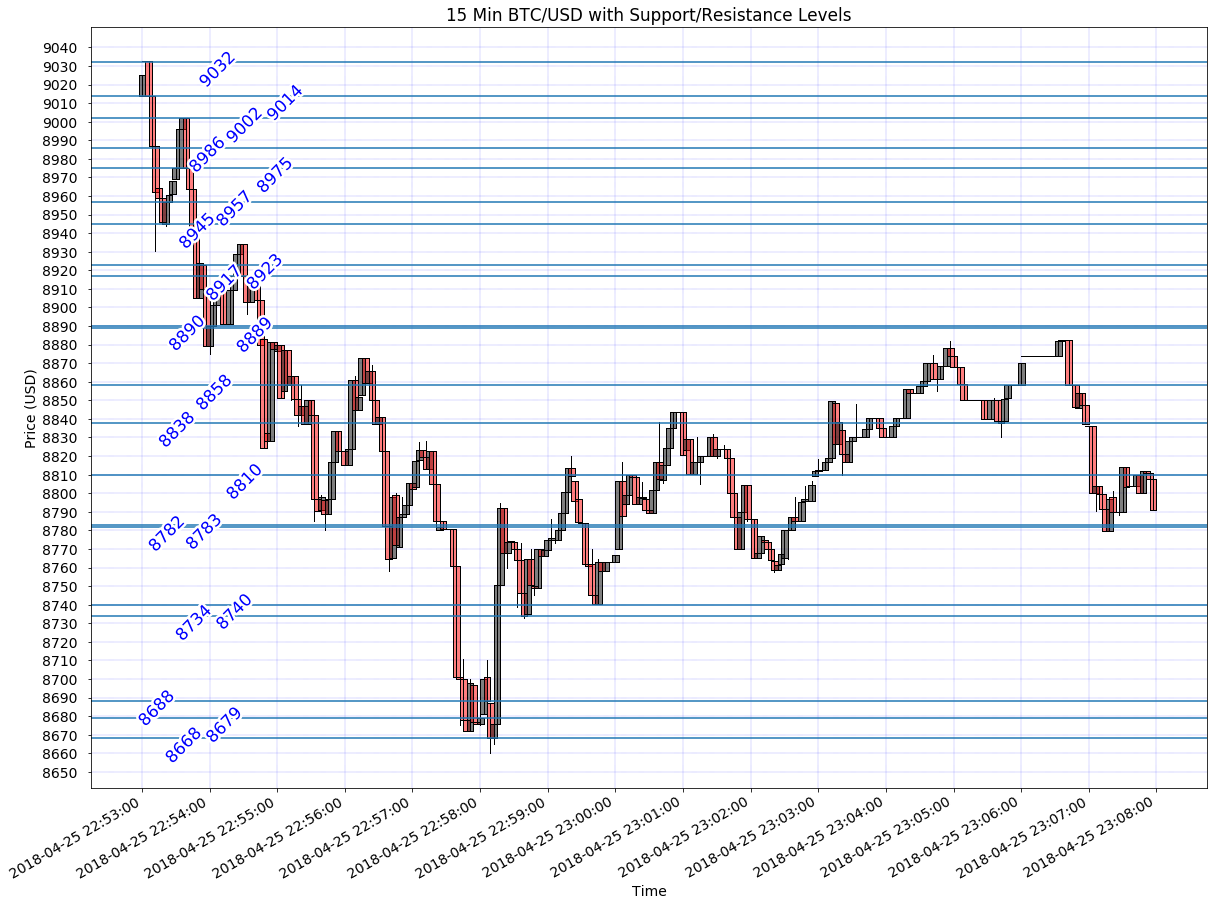

(array([8668, 8679, 8688, 8734, 8740, 8782, 8783, 8810, 8838, 8858, 8889,
        8890, 8917, 8923, 8945, 8957, 8975, 8986, 9002, 9014, 9032]), None)

In [117]:
# Plot the above data with autogenerated support and resistance levels for price 
    # Pass dataframe to autoSR() --> create chart + generate and plot auto S/R levels
    # Pass dataframe to autoSR() --> just generate S/R levels and return as array
autoSR(chart_15m_df), generate_chart(chart_15m_df)

In [118]:
# Format of snapshot before initalizing features:
snapshot_asks_df.head()
snapshot_bids_df.head()

,side,price,size
0,buy,9192.00,7.480407
1,buy,9191.15,1.086510
2,buy,9191.11,0.201300
3,buy,9191.00,4.631669
4,buy,9190.26,2.333950


In [119]:
# Create inital features of snapshot 
feature_creation_inital()
snapshot_bids_df.head()

run


,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,buy,9192.00,7.480407,0.0,-1,0,0,0
1,buy,9191.15,1.086510,0.0,-2,0,0,0
2,buy,9191.11,0.201300,0.0,-3,0,0,0
3,buy,9191.00,4.631669,0.0,-4,0,0,0
4,buy,9190.26,2.333950,0.0,-5,0,0,0


In [120]:
# Split l2update data from raw_data into 4 15-min segments
    # Pass l2update_df (1hr of data) into split function
    # output of this function: l2update_time_df
    
l2update_1hr_split(l2update_df)  

In [124]:
l2update_time_df.head()
#l2update_15min_1
#l2update_15min_2
#l2update_15min_3
#l2update_15min_3

,iso
l2update_15min_1,2018-04-24T03:52:17.202Z
l2update_15min_2,2018-04-24T04:07:44.745Z
l2update_15min_3,2018-04-24T04:23:58.885Z
l2update_15min_4,2018-04-24T04:40:49.111Z


In [125]:
l2update_15min_1.head()

,side,price,size,time
0,buy,9170.51,0.0100,2018-04-24T03:52:17.202Z
1,buy,9191.16,0.0015,2018-04-24T03:52:17.210Z
2,buy,9059.50,0.0000,2018-04-24T03:52:17.241Z
3,sell,9208.43,0.0000,2018-04-24T03:52:17.258Z
4,buy,9157.99,0.0015,2018-04-24T03:52:17.267Z


In [126]:
l2update_15min_2.head()

,side,price,size,time
0,buy,9214.98,12.974719,2018-04-24T04:07:44.745Z
1,sell,9230.94,0.000000,2018-04-24T04:07:44.750Z
2,buy,9198.26,0.500000,2018-04-24T04:07:44.768Z
3,sell,9230.44,0.500000,2018-04-24T04:07:44.771Z
4,buy,9214.98,13.974719,2018-04-24T04:07:44.782Z


In [127]:
l2update_15min_3.head()

,side,price,size,time
0,buy,9132.01,0.0000,2018-04-24T04:23:58.885Z
1,buy,9066.07,0.0015,2018-04-24T04:23:58.887Z
2,buy,9099.07,0.0015,2018-04-24T04:23:58.889Z
3,buy,9029.00,0.0570,2018-04-24T04:23:58.907Z
4,buy,9165.01,0.0015,2018-04-24T04:23:58.914Z


In [128]:
l2update_15min_4.head()

,side,price,size,time
0,buy,9144.26,0.112440,2018-04-24T04:40:49.111Z
1,buy,9144.26,0.120430,2018-04-24T04:40:49.201Z
2,buy,9220.88,8.217109,2018-04-24T04:40:49.203Z
3,buy,9183.05,0.010000,2018-04-24T04:40:49.205Z
4,sell,10142.98,0.010000,2018-04-24T04:40:49.214Z


In [129]:
l2update_time_df['iso'][1]

'2018-04-24T04:07:44.745Z'

In [151]:
# Test chart data request function that accepts an iso date for request start
    # Currently not working; each request currently returns the same request timeframe-wise
def ch15m_req_time(request_start):
    
    global chart_15m_df2
    request_start = request_start

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df2 =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df2 = chart_15m_df2[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df2.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df2['time'] =pd.to_datetime(chart_15m_df2['time'],unit='s')

In [152]:
ch15m_req_time(l2update_time_df['iso'][0])
chart_15m_1= chart_15m_df2
chart_15m_1.head()

,time,open,high,low,close,volume
299,2018-04-25 22:55:00,9014.06,9014.06,8986.76,8986.76,41.851820
298,2018-04-25 22:56:00,8986.76,8986.76,8930.49,8964.00,136.921817
297,2018-04-25 22:57:00,8964.10,8970.00,8958.10,8959.01,67.352111
296,2018-04-25 22:58:00,8959.01,8960.87,8949.00,8949.00,26.507064
295,2018-04-25 22:59:00,8945.00,8957.01,8944.04,8957.01,47.706218


In [153]:
ch15m_req_time(l2update_time_df['iso'][1])
chart_15m_2= chart_15m_df2
chart_15m_2.head()

,time,open,high,low,close,volume
299,2018-04-25 22:55:00,9014.06,9014.06,8986.76,8986.76,41.449569
298,2018-04-25 22:56:00,8986.76,8986.76,8930.49,8963.00,136.920817
297,2018-04-25 22:57:00,8964.10,8970.00,8958.10,8959.01,67.352111
296,2018-04-25 22:58:00,8959.01,8960.87,8945.90,8945.90,26.621864
295,2018-04-25 22:59:00,8945.00,8957.01,8944.04,8957.01,47.706218


In [154]:
ch15m_req_time(l2update_time_df['iso'][2])
chart_15m_3 =chart_15m_df2
chart_15m_3.head()

,time,open,high,low,close,volume
299,2018-04-25 22:55:00,9014.06,9014.06,8986.76,8986.76,41.449569
298,2018-04-25 22:56:00,8986.76,8986.76,8930.49,8962.00,136.919817
297,2018-04-25 22:57:00,8964.10,8970.00,8958.10,8959.01,67.352111
296,2018-04-25 22:58:00,8959.01,8960.87,8945.90,8945.90,26.621864
295,2018-04-25 22:59:00,8945.00,8957.01,8944.04,8957.01,47.706218


In [155]:
ch15m_req_time(l2update_time_df['iso'][3])
chart_15m_4 =chart_15m_df2
chart_15m_4.head()

,time,open,high,low,close,volume
299,2018-04-25 22:55:00,9014.06,9014.06,8986.76,8986.76,41.851820
298,2018-04-25 22:56:00,8986.76,8986.76,8930.49,8964.00,136.921817
297,2018-04-25 22:57:00,8964.10,8970.00,8958.10,8959.01,67.352111
296,2018-04-25 22:58:00,8959.01,8960.87,8949.00,8949.00,26.507064
295,2018-04-25 22:59:00,8945.00,8957.01,8944.04,8957.01,47.706218


In [ ]:
#### Preliminary code to address timezone issue for chart data scrape for API

print(request_log_df["iso"][1])
print(l2update_time_df["iso"][0])
# Actual -700 US/Mountain time conversion is:
    #2018-04-23T21:52:17.202-06:00

In [ ]:
import pytz
from datetime import datetime
from dateutil.tz import *
test_time = l2update_time_df["iso"][0]
print(test_time)
test_time_dt = pd.to_datetime(test_time)
print(test_time_dt)
#test_time.astimezone(pytz.timezone('America/New_York'))
print(test_time_dt.tz_localize('utc'))
test_time_dt_localized= test_time_dt.tz_localize('utc')
print("Converted to EST:")
test_time_dt_localized.astimezone("US/Eastern")

In [ ]:
l2_state_update()
sr_update()
snapshot_asks_df.head()

In [ ]:
snapshot_asks_df.count()

In [ ]:
snapshot_bids_df.count()

In [ ]:
#Check to make sure 'is_line' value was properly set
snapshot_asks_df.loc[snapshot_asks_df['is_line' ] == 1]

In [ ]:
snapshot_bids_df.loc[snapshot_bids_df['is_line' ] == 1]